In [1]:
import sys
sys.path.append('G:/My Drive/Research/adaptation_abm/code')
import model.model as mod
import plot.single_run as plt
import imp
import numpy as np
imp.reload(plt)
imp.reload(mod)

inputs = {
    'model' : {
        'n_agents' : 100,
        'T' : 40, # number of years to simulate
        'exp_name' : 'test',
        'seed' : 0,
        'sim_id' : 0,
        'rep_id' : 0,
        'adaptation_option' : 'cover_crop' # set to a random string for baseline
    }, 
    'adaptation' : {
            'insurance' : {
                'climate_percentile' : 0.1,
                'payout_magnitude' : 1, # relative to the expected yield (assuming perfect soil quality). if =1.5, then payout = 1.5*expected_yield
            },
        'cover_crop' : {
            'N_fixation' : 80, # 80kg/ha representative of values reported in the literature. wittwer2017, buechi, couedel2018
            'cost_factor' : 1, # assume the cost is the same as the annual cost of insurance multiplied by this factor
        }
    },
    'agents' : {
        # adaptation / decision-making
        'adap_type' : 'affording', # coping, switching, or affording

        # plot ownership
        'land_heterogeneity' : True, # heterogeneity in number of plots?
        'land_mean' : 11.5, # mean number of land parcels. if heterogeneous, use poisson distribution
        
        ##### cash + wealth #####
        # initial (normal distribution)
        'wealth_init_mean' : 15000,
        'wealth_init_sd' : 0,
        'max_wealth' : 3000*40, # 3000birr/head livestock and no ppl with more than 40 livestock. kind of from LSMS. a bit artibrary
        # requirements
        'cash_req_mean' : 17261/2, # birr/yr. median value from 2015 LSMS
        'cash_req_sd' : 0,
        # market prices
        'crop_sell_price' : 2.17, # birr/kg. mean 2015 maize price (FAO)
        'fertilizer_cost' : 13.2, # birr/kg. median from 2015 LSMS
    },
    'land' : {
        ##### SOM #####
        # initial vals
        'organic_N_min_init' : 300, # kgN/ha. similar to initial value in Li2004
        'organic_N_max_init' : 300,
        # soil model
        'max_organic_N' : 1000, # kgN/ha. arbitrary (set in relation to the initial value)
        'mineralization_rate' : 0.25, # rate of mineralization from organic->inorganic (assume linear decay). taken loosely from berg2008: k=0.3-->exp(-0.3)~=0.75, so 0.25 mineralized
        'loss_max' : 0.5, # inorganic loss fraction with no SOM. Di2002 data had ~50% maximum leaching rates of N
        'loss_min' : 0.05, # inorganic loss fraction with maximum SOM. Di2002 had ~5% minimum leaching.
        'wealth_N_conversion' : 0.026, # kgN/yr per birr. a proxy for livestock manure. derived as 3000birr/head and using values from Newcombe1987. nitrogen %age in manure also similar in Lupwayi2000

        ##### yield #####
        'area' : 0.13, # ha. mean in LSMS 2015
        'max_yield' : 6590, # kg/ha. maximum, unconstrained yield. 95%ile for Ethiopia-wide LSMS (all 3 years) maize yields
        'rain_crit' : 0.8, # value at which rainfall starts to be limiting. 0.8 in CENTURY
        'rain_cropfail_high_SOM' : 0, # rainfall value at which crop yields are 0 with highest SOM. arbitrary
        'rain_cropfail_low_SOM' : 0.1, # rainfall value at which crop yields are 0 with lowest SOM. arbitrary
        'random_effect_sd' : 0, # std dev of yield multiplier effect (normal distribution, mu=1)
        'crop_CN_conversion' : 50, # from Century model curves (middle of the y axis) -- pretty arbitrary. represents C:N ratio kind of
    },
    'climate' : {
        # annual climate measure -- assume normal distribution (truncated to [0,1])
        'rain_mu' : 0.5, # approximately fits country-wide CYF distribution for maize (BUT this variable is rain not CYF)
        'rain_sd' : 0.2,
    }
}

G:/My Drive/Research/adaptation_abm/code\model\land.py:111: RuntimeWarning: invalid value encountered in true_divide
  self.nutrient_factors[t] = self.yields[t] / self.yields_unconstrained[t]


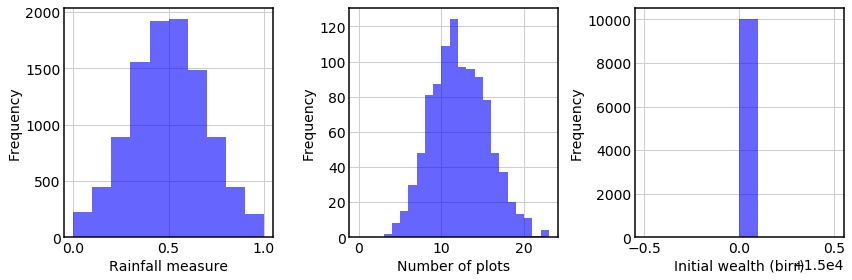

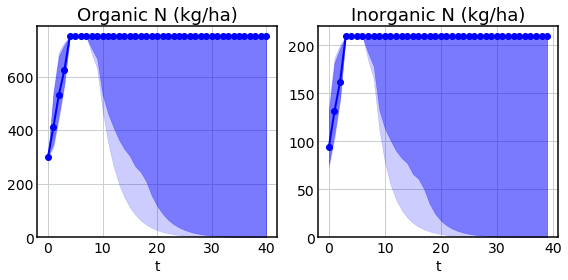

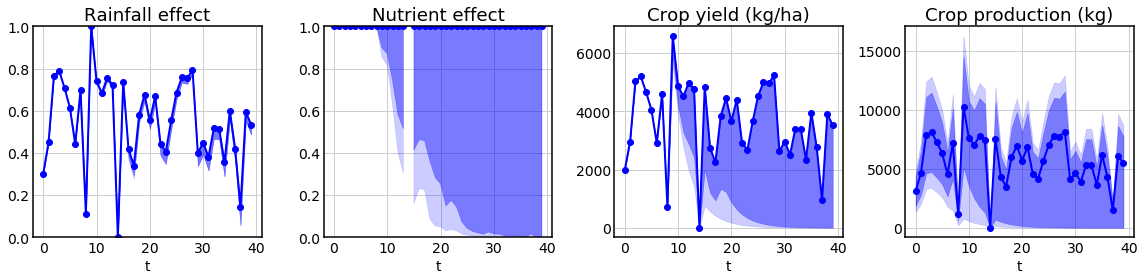

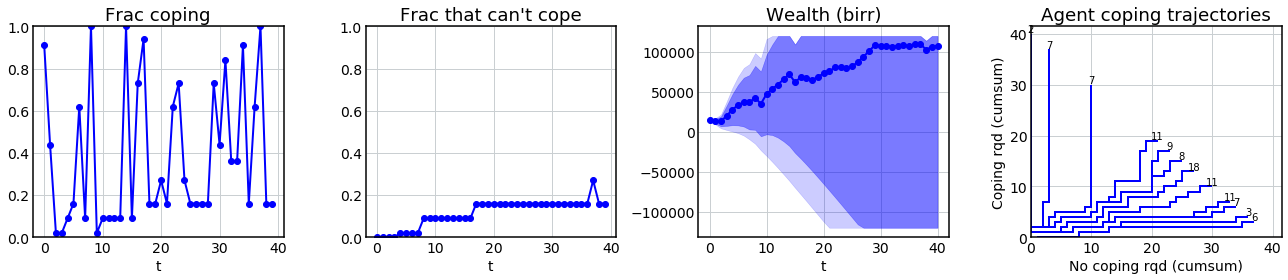

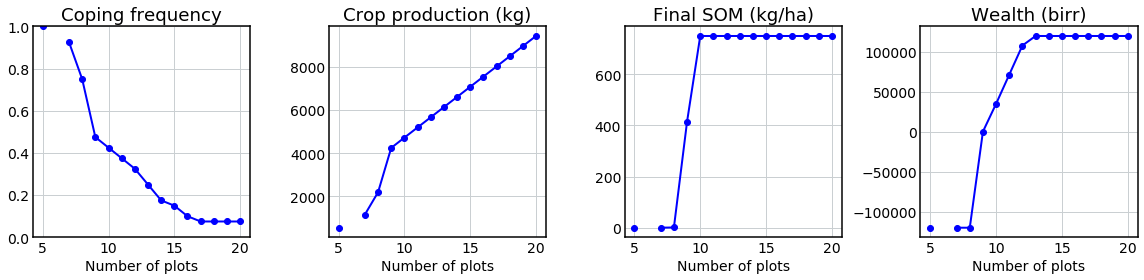

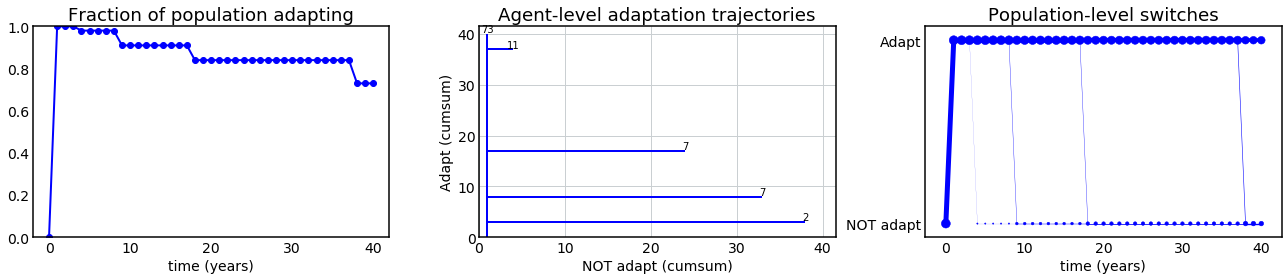

In [2]:
m = mod.Model(inputs)
for t in range(m.T):
    m.step()
plt.main(m, save=False)